In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from IPython.display import Image

In [2]:
#Τhe matrices A,B and the image G as a matrix
A, B, G = [], [], []

#The number of lines of the data
n = 49152

#I am reading the data file
with open("data", "r") as data_file:
    
    #I have 3 matrices
    for i in range(int(n/3)):
        #I read the matrices as flatten vectors
        #Matrix A
        line_1 = data_file.readline().split()
        A.append(line_1)
        
    for j in range(int(n/3),int((2/3)*n)):
        #Matrix B
        line_2 = data_file.readline().split()
        B.append(line_2)
        
    for k in range(int((2/3)*n),n):
        #Image G, as  flatten vector
        line_3 = data_file.readline().split()
        G.append(line_3)

In [3]:
#We create matrices with the shape of 256x256

#Matrix A
A=np.reshape(A,(256,256))
A=A.astype(float)

#Matrix B
B=np.reshape(B,(256,256))
B=B.astype(float)

#Image G
G=np.reshape(G,(256,256))
G=G.astype(float)

(-0.5, 255.5, 255.5, -0.5)

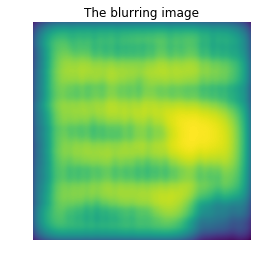

In [4]:
#The image before any preprocessing(the blurring image)
plt.imshow(G,interpolation='bilinear')
plt.title('The blurring image')
plt.axis('off')

### a) Tikhonov regularization



At first, I need to apply the svd analysis for the matrices A and B

In [5]:
#svd analysis for matrix A
Ua, Sa, VTa = svd(A)

#svd analysis for matrix B
Ub, Sb, VTb = svd(B)

As our main matrix is in ill-condition, we need to apply the algorithm that is described in the pdf file. 
My analysis is based on the below theorem.


<img src="nnn.png" style="height:150px">

In [6]:
#The g hat based on the Kronecker product
G_trans=  np.dot((np.transpose(Ub)),np.dot(G,Ua))

#I reshape matrix Sa and Sb
Sa=np.reshape(Sa,(256,1))
Sb=np.reshape(Sb,(256,1))

#The Kronecker product of S
S= np.dot(Sb,np.transpose(Sa))

In [7]:
#The list with the hyperparameters that I will tune for the task
a=[0.0001,0.001,0.0015,0.0025,0.005,0.025,0.05,0.25,0.5]

#The function that will return us the deblurred image
def plot_image(a):
    #I apply the definition of the Tikhonov regularization
    F_trans=np.divide(np.multiply(S,G_trans), (np.multiply(S,S)+a**2))
    F=np.dot(np.transpose(VTb),np.dot(F_trans,VTa))
    plt.imshow(F,interpolation='bilinear')
    plt.title('The image with a = '+ str(a))
    plt.axis('off')

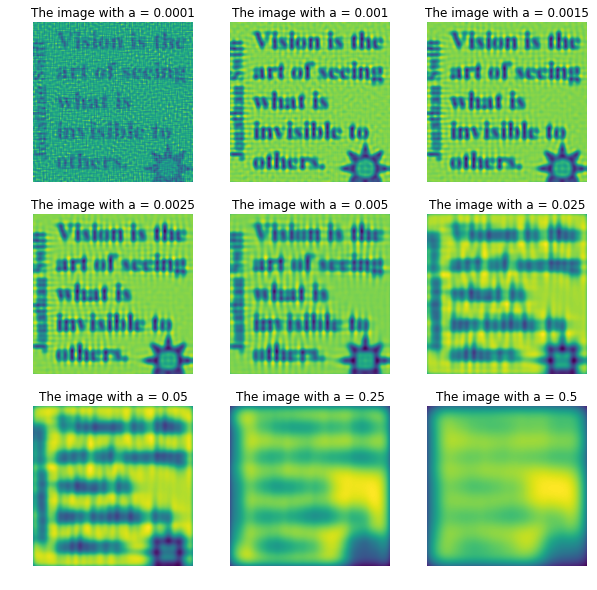

In [8]:
plt.figure(figsize=(10,10))
for i in range(len(a)):
    plt.subplot(3,3,i+1)
    plot_image(a[i])
    

We can see that from the first value of a (a=0.0001), we can read easily the message of the image. However, with a=0.001, there is a balance between the colours and the picture is way more clear. 

### b) Truncated SVD

We will use the SVD analysis that we did before, but also the matrix G_star, that is constructed from the matrices of the SVD analysis. 

Now, we need to find a paremeter p to truncate the expansion of the solution
in order to eliminate effects due to very small singular values. So, that value must be less than our a (from the previous task) plus one very small number.

In [9]:
#The matrix F after the SVD analysis
F_trans = np.divide(G_trans,S)

#the definition of the function for the Truncated SVD
def trunc_svd(scalar):
    #The matrix that defines which values are less than a specific value 
    trunc_matrix = np.zeros(shape=(256,256))
    
    #If the value of the singular value is greater than a specific scalar, I set True at the truncated matrix 
    for i in range(256):
        for j in range(256):
            if S[i][j] > scalar + 1e-12:
                trunc_matrix[i][j] = 1
            else:
                trunc_matrix[i][j] = 0
    
    
    #The new matrix F, which is product of the truncated matrix 
    F_new= np.multiply(F_trans,trunc_matrix)
    
    #The definition of the Tikhonov regularization
    F= np.dot(np.transpose(VTb),np.dot(F_new,VTa))
    
    #I need to find the number of values that are needed for the truncated analysis
    param_p=0
    for i in range(256):
        for j in range(256):
            if trunc_matrix[i][j] == 1:
                param_p = param_p + 1
                
    plt.imshow(F,interpolation='bilinear')
    plt.title('For p='+''+ str(param_p))    
    plt.axis('off')

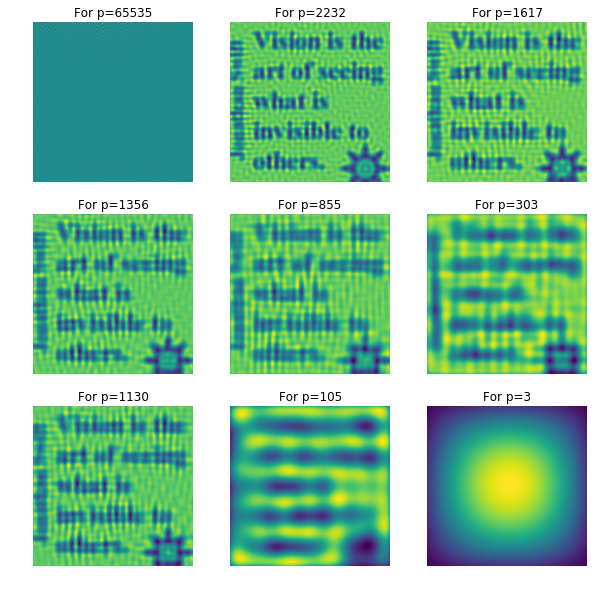

In [10]:
plt.figure(figsize=(10,10))
scalar = [0,0.0012,0.0024,0.0034,0.0087,0.034,0.005,0.1,0.7]
for i in range(len(a)):
    plt.subplot(3,3,i+1)
    trunc_svd(scalar[i])

We can easily see that we have a similar result as before. With a=0.001 we obtain the best photo. But there is an interesting part relative to the parameter p. As that parameter is decreased, the image is getting worse and worse (worse than the Tikhonov regularization). That makes sense, because if p is really small, means that we have removed a lot information and we cannot depict the image. 


You will find more details in the attached report. 